# YOLO. Детекция объектов

## Данные

Разметка находится в xmls папке, картинки в images.

In [1]:
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip

!unzip -q data.zip

--2023-12-09 13:12:44--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-09 13:12:44--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   201MB/s    in 0.2s    

2023-12-09 13:12:44 (201 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Создание Dataset

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    filename = image_name.split("/")[-1].split(".")[0]
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    bboxes = []
    for member in treeroot.findall("object"):
        class_name = member.find("name").text
        class_key = class_dict[class_name]

        bbox = member.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        res = [xmin, ymin, xmax, ymax, class_key]
        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]
        image = np.array(Image.open(self.filenames[idx]).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Визуализация картинок

In [7]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        img = images[i].permute(1, 2, 0).numpy()
        img = (img * std) + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, class_id = bbox
            class_name = train_ds.class_dict_inv[class_id]
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, class_name, fontsize=8, color='r')

    fig.tight_layout()
    plt.show()

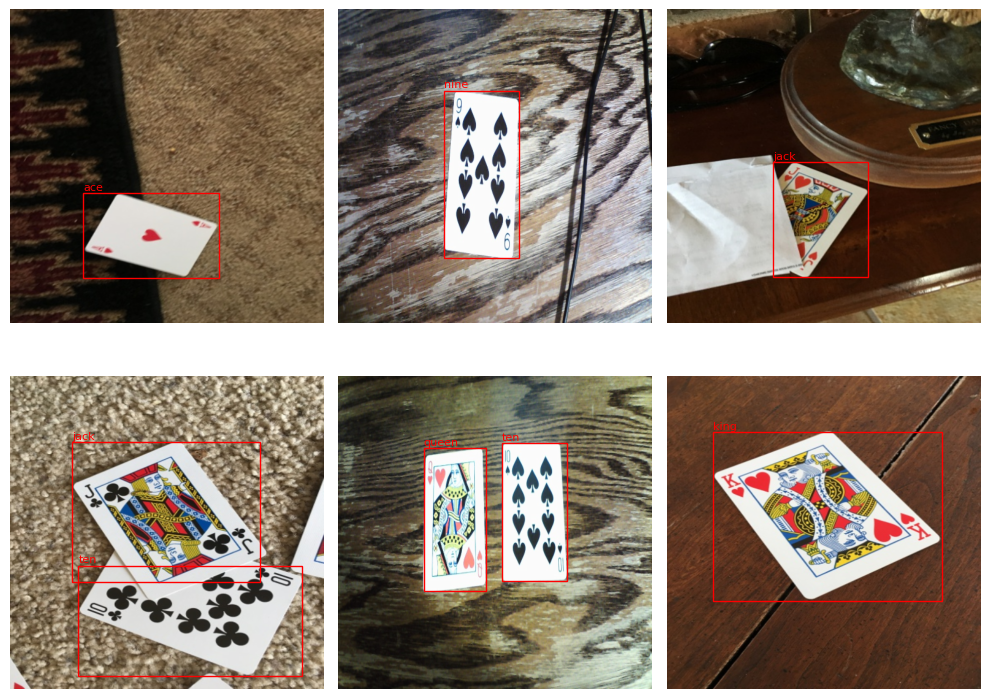

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# YOLO-like детектор

## Collate function

Для генерации тензоров размера Bx16x16x6, где B - количество примеров в батче

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box = (xmax - xmin)/w
        h_box = (ymax - ymin)/h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax)/2
        cy = (ymin + ymax)/2
        cx_idx = (cx//downsample).long()
        cy_idx = (cy//downsample).long()

        cx_box = (cx%downsample)/downsample
        cy_box = (cy%downsample)/downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

## Decoder function

Обратное преобразование (относительно Collate function) полученных тензоров в картинки

In [11]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    boxes = []
    for batch in range(b):
        for x in range(w):
            for y in range(h):
                cx_box, cy_box, w_box, h_box, obj_prob = pred[batch, :5, y, x]

                if c == 6:
                    class_idx = pred[batch, 5, y, x]
                else:
                    class_probs = pred[batch, 5:, y, x]
                    class_idx = class_probs.argmax()

                if obj_prob > threshold:
                    range_x = w_box*img_w
                    range_y = h_box*img_h
                    bias_cx = cx_box*upsample
                    bias_cy = cy_box*upsample
                    cx = upsample*x + bias_cx
                    cy = upsample*y + bias_cy
                    xmin = cx - range_x/2
                    xmax = cx + range_x/2
                    ymin = cy - range_y/2
                    ymax = cy + range_y/2

                    boxes.append((int(xmin), int(ymin), int(xmax), int(ymax), int(class_idx)))

    return boxes

## Архитектура

In [12]:
C = 6
import torchvision.models as models

class Detector(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = models.resnet50(pretrained=True)
        self.resnet_blocks = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4
        )


        self.additional_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.resnet_blocks(img)
        x = self.additional_blocks(x)
        x = self.sigmoid(x)

        return x

## Функция потерь

In [13]:
import torch
import torch.nn as nn

def special_loss(pred, target, check=False, C=C):
    mask = target[:, 4, :, :] > 0

    localization_loss = nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 0, :, :], mask), torch.masked_select(pred[:, 0, :, :], mask)) + nn.MSELoss(reduction='sum')(
        torch.masked_select(target[:, 1, :, :], mask), torch.masked_select(pred[:, 1, :, :], mask))

    box_loss = nn.MSELoss(reduction='sum')(torch.masked_select(target[:, 2, :, :] ** 0.5, mask), torch.masked_select(pred[:, 2, :, :], mask)
        ) + nn.MSELoss(reduction='sum')(torch.masked_select(target[:, 3, :, :] ** 0.5, mask), torch.masked_select(pred[:, 3, :, :], mask))

    arr = []
    for index in range(C):
        arr.append(torch.masked_select(pred[:, 5+index, :, :], mask))
    pr = torch.stack(arr, 1)
    tar = torch.masked_select(target[:, 5, :, :], mask)
    classification_loss = nn.CrossEntropyLoss(reduction='sum')(pr, tar.long())

    confidence_loss = nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, : ], mask), torch.masked_select(target[:, 4, :, : ], mask)
        ) + 0.1 * nn.BCELoss(reduction='sum')(torch.masked_select(pred[:, 4, :, : ], ~mask
        ), torch.masked_select(target[:, 4, :, : ], ~mask))


    if not check:
        return 10 * localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

# Обучение

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 6, collate_fn=collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(21)
EPOCHS = 30
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:

        imgs = batch["image"].to(device)
        targets = batch["target"].to(device)

        opt.zero_grad()
        outputs = model(imgs)
        loss = special_loss(outputs, targets)
        loss.backward()
        opt.step()
        epoch_losses.append(loss.item())

        pbar.set_description(f"Epoch {e} loss: {loss.item():.3f}")  # отображаем прогресс обучения
    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 0 done; Train loss 71.543;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1 done; Train loss 41.895;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2 done; Train loss 35.849;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3 done; Train loss 33.660;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4 done; Train loss 29.622;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5 done; Train loss 29.274;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6 done; Train loss 27.172;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7 done; Train loss 28.172;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8 done; Train loss 25.822;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9 done; Train loss 23.259;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10 done; Train loss 22.100;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11 done; Train loss 21.269;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12 done; Train loss 21.995;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13 done; Train loss 25.140;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14 done; Train loss 25.317;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15 done; Train loss 22.602;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16 done; Train loss 19.984;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17 done; Train loss 18.702;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18 done; Train loss 19.116;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19 done; Train loss 18.831;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20 done; Train loss 18.974;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 21 done; Train loss 17.902;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 22 done; Train loss 17.694;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 23 done; Train loss 19.271;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 24 done; Train loss 19.409;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 25 done; Train loss 18.600;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 26 done; Train loss 18.005;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 27 done; Train loss 17.358;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 28 done; Train loss 16.829;


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 29 done; Train loss 17.096;


In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [18]:
images, target = batch['image'], batch['target']

pred = []
for image in images:
    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = model(image.to(device))
        pred.append(outputs.to('cpu'))

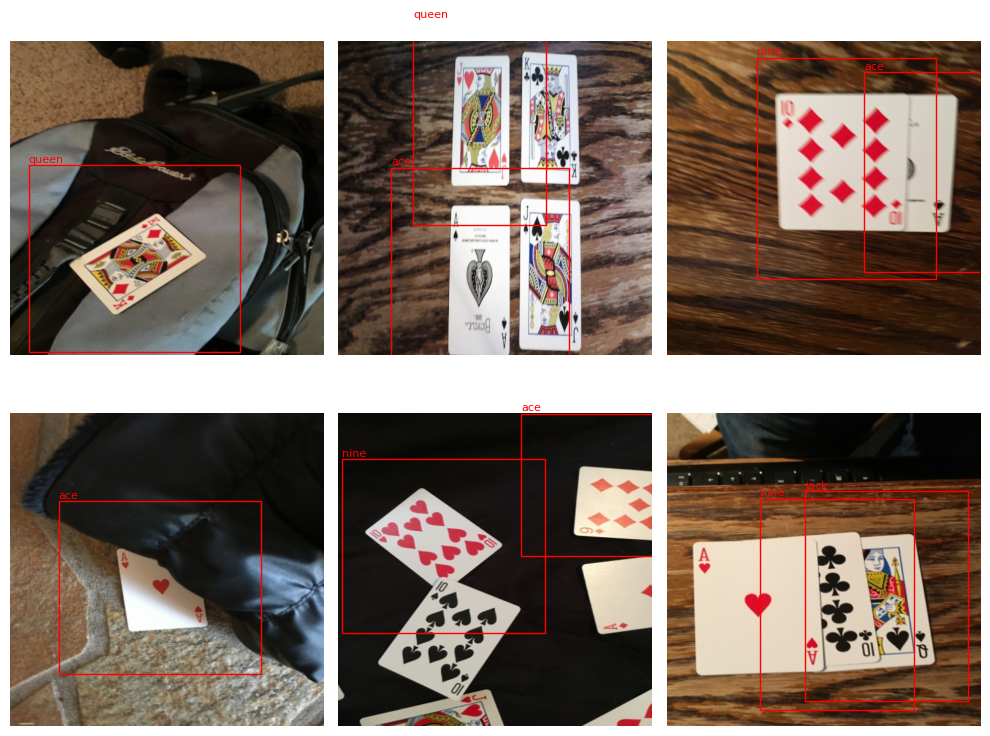

In [19]:
visualize([img for img in images], [decode_prediction(result) for result in pred])

# Готовая архитектура YOLO v8 от ultralytics

In [20]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 8.7 MB/s eta 0:00:00


## Подготовка данных

In [21]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

In [22]:
def annotation2txt(bboxes, w_im, h_im):
    yolo_annotations = []

    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_idx = bbox

        x_center_norm = (xmin + xmax) / 2 / w_im
        y_center_norm = (ymin + ymax) / 2 / h_im

        width_norm = (xmax - xmin) / w_im
        height_norm = (ymax - ymin) / h_im

        yolo_annotations.append(f"{class_idx} {x_center_norm} {y_center_norm} {width_norm} {height_norm}")

    return yolo_annotations

In [23]:
for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [24]:
nc =  6
names = ["king", "jack", "ace", "ten", "nine", "queen"]

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Обучение

In [25]:
import ultralytics

model = ultralytics.YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=100, imgsz=512, device=0)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 37.4MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 71.8MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 639.33it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 631.58it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.56G      3.186      4.594       4.38         21        512: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         37         68   0.000544     0.0802   0.000652    9.2e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.27G      3.136      4.231      4.119         18        512: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         37         68   0.000643     0.0931    0.00045   6.22e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      3.048      3.851      3.856         31        512: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         37         68    0.00041     0.0523   0.000275   3.34e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.29G      2.925      3.531      3.569         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         37         68     0.0003     0.0395   0.000217   3.48e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.28G      2.765      3.381      3.388         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         37         68     0.0624     0.0465     0.0324     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.29G      2.704      3.316      3.243         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         37         68     0.0902      0.146     0.0868     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.28G      2.569      3.053      3.076         24        512: 100%|██████████| 21/21 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         37         68      0.188       0.26       0.17     0.0888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.29G      2.391      2.967      2.928         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         37         68      0.293      0.236      0.229      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.28G      2.232       2.82      2.787         29        512: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         37         68      0.313      0.605      0.306      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.29G      2.137      2.739      2.724         24        512: 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         37         68      0.634       0.24      0.246      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.27G      1.969      2.547       2.53         20        512: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         37         68      0.351      0.582      0.404      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.29G       1.84      2.532      2.452         18        512: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         37         68      0.297      0.516      0.403      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.28G       1.79      2.387      2.348         22        512: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


                   all         37         68      0.409      0.572      0.434      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.31G      1.771      2.346      2.321         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         37         68      0.339      0.483      0.338      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.29G      1.624      2.201      2.195         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         37         68      0.403      0.639      0.518       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.28G      1.582      2.199      2.143         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         37         68      0.431      0.641      0.517      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.27G      1.559      2.129      2.123         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         37         68       0.32      0.616      0.459       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.29G       1.46      2.052      2.055         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         37         68      0.422      0.713      0.522      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.29G      1.432      2.105      2.021         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         37         68      0.382      0.717      0.501      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.29G      1.388      1.926      1.954         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


                   all         37         68      0.493      0.664      0.563      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.28G      1.381      1.901      1.936         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


                   all         37         68      0.461       0.69      0.516      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.28G        1.3      1.852      1.857         11        512: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         37         68       0.44      0.732      0.527      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.28G      1.293      1.833       1.85         29        512: 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


                   all         37         68      0.486      0.715      0.562      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.29G      1.334      1.877      1.898         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         37         68      0.463      0.835      0.571      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.28G      1.276      1.817      1.818         23        512: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         37         68      0.491      0.719      0.604       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.29G      1.296      1.784      1.859         33        512: 100%|██████████| 21/21 [00:05<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


                   all         37         68      0.475      0.759      0.585      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.28G       1.27      1.798      1.809         23        512: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         37         68      0.464      0.797      0.626      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.29G      1.179      1.693      1.724         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         37         68      0.484      0.849      0.631      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.27G       1.19      1.761      1.737         14        512: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         37         68      0.474      0.851      0.562       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.29G      1.217      1.694      1.749         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         37         68      0.438      0.827      0.605      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.29G      1.152      1.634      1.695         26        512: 100%|██████████| 21/21 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         37         68      0.493      0.901      0.664      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.29G       1.15      1.651      1.696         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         37         68      0.522      0.749      0.671      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.26G      1.124      1.621      1.667         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         37         68      0.527      0.751      0.603      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.29G      1.115      1.603      1.631         30        512: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         37         68      0.448      0.846      0.633      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.28G      1.056      1.546      1.577         21        512: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         37         68      0.477      0.741       0.64      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.28G      1.016      1.528      1.587         25        512: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         37         68      0.518      0.899       0.65      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.26G      1.021      1.514      1.565         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         37         68      0.492      0.908      0.705      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.29G      1.002      1.492      1.544         27        512: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         37         68       0.53      0.791      0.653      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.29G     0.9828      1.471      1.522         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         37         68      0.624      0.818      0.711      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.29G       1.03      1.497      1.553         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         37         68      0.559      0.794      0.713      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.27G     0.9824      1.453      1.529         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         37         68      0.621      0.861      0.745      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.29G     0.9992      1.436      1.529         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         37         68      0.619      0.783      0.716      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.28G     0.9498      1.418      1.494         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         37         68      0.735      0.709      0.797      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.29G     0.9346      1.382      1.472         19        512: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         37         68      0.518      0.894      0.743      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.27G     0.9411      1.413      1.496         27        512: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         37         68      0.583      0.839       0.71       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.29G     0.9576       1.43      1.514         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         37         68      0.516      0.865      0.695      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.29G     0.9213      1.397      1.449         23        512: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


                   all         37         68      0.548      0.817      0.733      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.29G     0.9551      1.412      1.476         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


                   all         37         68      0.574       0.89       0.72      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.26G      0.892      1.346      1.444         27        512: 100%|██████████| 21/21 [00:06<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         37         68      0.541      0.888      0.746      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.29G     0.8963      1.328      1.445         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         37         68      0.547      0.863      0.747      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.28G     0.9103      1.316      1.437         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         37         68      0.644      0.857      0.796      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.27G     0.9272      1.329       1.46         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         37         68      0.684      0.863      0.821      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.27G     0.8716      1.272      1.398         15        512: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         37         68      0.687      0.839      0.798      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.29G     0.9191      1.314      1.454         18        512: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]


                   all         37         68      0.736      0.819      0.789      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.29G     0.8648      1.254      1.423         22        512: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         37         68      0.694      0.803      0.797      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.29G     0.8638        1.3      1.412         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         37         68      0.678      0.724      0.795      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.28G     0.8349      1.229      1.385         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         37         68      0.719      0.832      0.844       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.28G     0.8782      1.223      1.417         18        512: 100%|██████████| 21/21 [00:06<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         37         68       0.69      0.863      0.793      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.29G     0.8391      1.245      1.379         28        512: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         37         68      0.658       0.92      0.815        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.29G     0.8309      1.218      1.354         21        512: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         37         68      0.648       0.88      0.818      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.26G     0.8344      1.218      1.371         32        512: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         37         68      0.679      0.852       0.78      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.28G     0.8172      1.191      1.339         13        512: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         37         68      0.758      0.849      0.887      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.28G      0.816      1.188      1.362         25        512: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


                   all         37         68      0.722      0.869      0.852      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.28G     0.8532       1.19      1.382         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         37         68      0.736      0.935      0.859      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.28G     0.8241      1.205      1.357         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         37         68      0.677      0.914      0.829      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.31G     0.8244      1.199      1.373         27        512: 100%|██████████| 21/21 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         37         68      0.852      0.822      0.871      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.29G     0.8578       1.25      1.398         12        512: 100%|██████████| 21/21 [00:06<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         37         68      0.752      0.839      0.835      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.27G     0.8013      1.179      1.334         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         37         68      0.753      0.893      0.888      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.27G      0.792      1.165      1.332         19        512: 100%|██████████| 21/21 [00:06<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         37         68      0.639      0.942      0.851      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.29G     0.8003      1.134      1.337         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         37         68       0.77      0.807      0.876      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.28G     0.8032      1.148      1.332         21        512: 100%|██████████| 21/21 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         37         68      0.773       0.86      0.911      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.28G     0.7895      1.128      1.312         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         37         68      0.787       0.79      0.877      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.28G     0.7949      1.154      1.323         16        512: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         37         68       0.75      0.812      0.885      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.29G     0.7674      1.091      1.309         28        512: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         37         68      0.816      0.904      0.911      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.29G      0.734      1.055      1.283         16        512: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


                   all         37         68      0.764      0.799      0.843      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.27G     0.7489      1.077      1.286         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         37         68      0.711      0.784      0.802      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.27G     0.7539      1.074      1.303         21        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         37         68      0.763      0.866      0.886      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.29G     0.7483      1.067       1.29         22        512: 100%|██████████| 21/21 [00:06<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         37         68      0.738      0.884      0.891      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.28G     0.7291      1.044      1.297         22        512: 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         37         68      0.632      0.848      0.826      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.27G     0.7573      1.054       1.31         22        512: 100%|██████████| 21/21 [00:05<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         37         68      0.881      0.862       0.94      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.28G     0.7526      1.036      1.298         19        512: 100%|██████████| 21/21 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         37         68      0.843      0.815      0.906      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.29G     0.7112      1.024      1.253         33        512: 100%|██████████| 21/21 [00:04<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         37         68      0.876      0.863      0.931      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.28G     0.7526      1.027      1.282         16        512: 100%|██████████| 21/21 [00:05<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


                   all         37         68      0.912      0.877      0.946      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.29G     0.7249      1.037      1.278         20        512: 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         37         68      0.825      0.846      0.908        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.28G     0.7394       1.04      1.295         28        512: 100%|██████████| 21/21 [00:06<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         37         68      0.747      0.884      0.895      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.29G     0.7158     0.9841      1.288         15        512: 100%|██████████| 21/21 [00:04<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         37         68       0.86      0.892      0.941      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.29G     0.6919     0.9595      1.249         19        512: 100%|██████████| 21/21 [00:05<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         37         68      0.949      0.848       0.95      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.29G     0.7043     0.9742      1.245         26        512: 100%|██████████| 21/21 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         37         68      0.957      0.843       0.95      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.3G     0.6715     0.9623      1.238         17        512: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         37         68      0.921      0.856      0.953      0.843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.29G     0.6865     0.9413      1.243         19        512: 100%|██████████| 21/21 [00:05<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

                   all         37         68       0.93      0.843       0.95      0.851


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.27G     0.6084     0.8657      1.185         15        512: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         37         68      0.849      0.882      0.958      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.27G     0.5801     0.8321       1.16         11        512: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         37         68      0.953      0.847      0.951      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.26G     0.5526     0.7992      1.124         12        512: 100%|██████████| 21/21 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         37         68      0.908       0.74      0.898      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.27G     0.5605      0.796      1.133         11        512: 100%|██████████| 21/21 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         37         68      0.935      0.879       0.94      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.27G     0.5494     0.7638      1.119         10        512: 100%|██████████| 21/21 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         37         68      0.869       0.86      0.938      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.27G      0.535     0.7603      1.133         14        512: 100%|██████████| 21/21 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         37         68      0.907      0.869      0.939      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.26G     0.5381     0.7401      1.115         14        512: 100%|██████████| 21/21 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         37         68      0.956      0.875      0.948      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.27G     0.5172      0.704      1.101         10        512: 100%|██████████| 21/21 [00:04<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         37         68      0.865      0.893      0.941      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.27G     0.5248      0.711      1.105          8        512: 100%|██████████| 21/21 [00:05<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         37         68      0.954      0.869      0.951      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.27G     0.5436     0.7043      1.121          8        512: 100%|██████████| 21/21 [00:04<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         37         68      0.946      0.847      0.949      0.846



100 epochs completed in 0.194 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


                   all         37         68      0.953       0.87      0.951      0.853
                  king         37         12      0.912      0.917      0.955      0.877
                  jack         37          8          1      0.749       0.88      0.783
                   ace         37         16      0.884      0.949      0.973      0.891
                   ten         37         11      0.965      0.909      0.967      0.858
                  nine         37         13       0.96          1      0.995      0.912
                 queen         37          8          1      0.695      0.933      0.799
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


## Визуализация полученных результатов

In [27]:
import os
valid_name = os.listdir('valid/images')

dirs = []
for name in valid_name:
  img_path = os.path.join('valid/images', name)
  img = Image.open(img_path)
  res = model(img, save=True)
  dirs.append(res[0].save_dir)


0: 512x384 1 ten, 98.4ms
Speed: 2.3ms preprocess, 98.4ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train2

0: 512x384 1 ace, 10.4ms
Speed: 2.1ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train3

0: 512x384 1 ten, 1 nine, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train4

0: 512x384 1 ten, 13.4ms
Speed: 3.1ms preprocess, 13.4ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train5

0: 288x512 1 king, 2 jacks, 1 ace, 87.1ms
Speed: 2.1ms preprocess, 87.1ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 512)
Results saved to runs/detect/train6

0: 512x384 1 ace, 19.1ms
Speed: 2.8ms preprocess, 19.1ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 384)
Results saved to runs/detect/train7

0: 512x384 1 queen, 

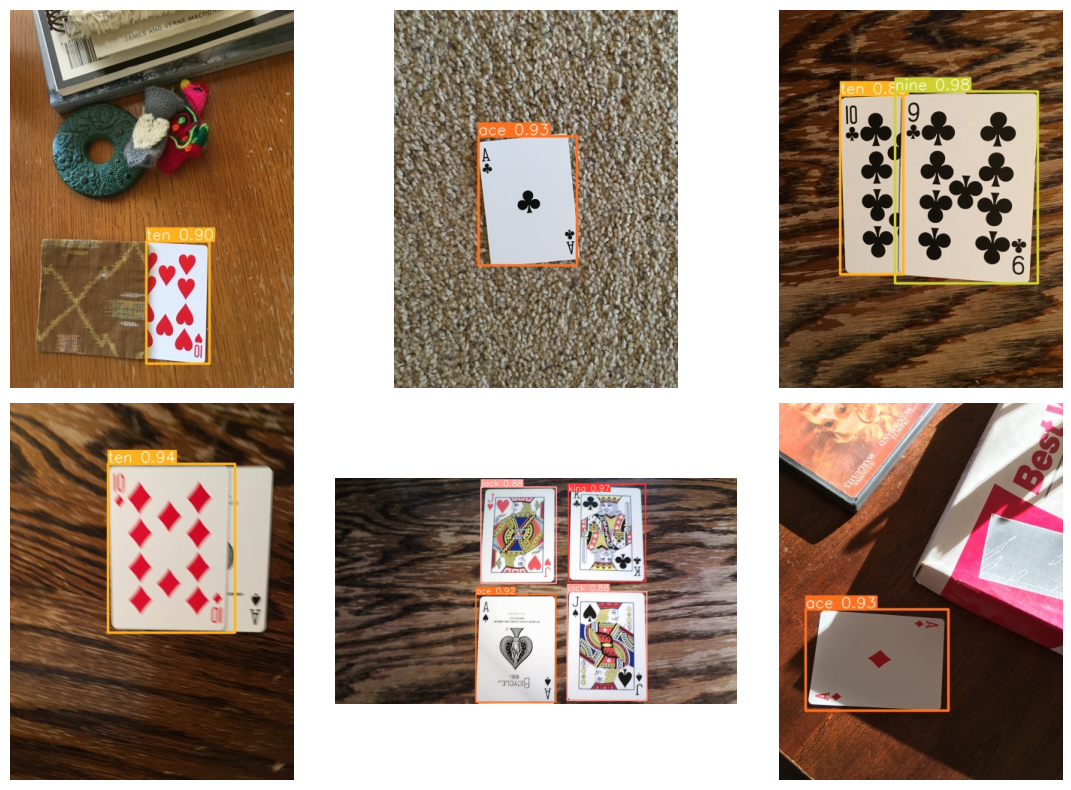

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

n = 0
for dir in dirs[:6]:
  img_name = os.listdir(dir)[0]
  path = os.path.join(dir, img_name)
  image = np.array(Image.open(path))
  axes[n].imshow(image)
  axes[n].axis('off')

  n+=1

plt.tight_layout()
plt.show()